<a href="https://colab.research.google.com/github/JaganFoundr/PyTorchNN/blob/main/Improved%20CNN/ImprovedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#1
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#2 Applying data normalization and data augmentation
statistic=((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) #mean and std deviation
train_transform = tt.Compose([tt.RandomCrop(size=32, padding=4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*statistic)]) # normalizing and augmenting the training set

test_transform = tt.Compose([tt.ToTensor(),
                             tt.Normalize(*statistic)]) #normalising the test set

# downloading the datasets and applying the transforms (for a moment training set is completely taken for training without
#splitting and testset is taken for validation and also for testing.
dataset=CIFAR10(root='./data', download=True, train=True, transform=train_transform)
validation_testset=CIFAR10(root='./data', download=True, train=False, transform=test_transform)
len(dataset)

Files already downloaded and verified
Files already downloaded and verified


50000

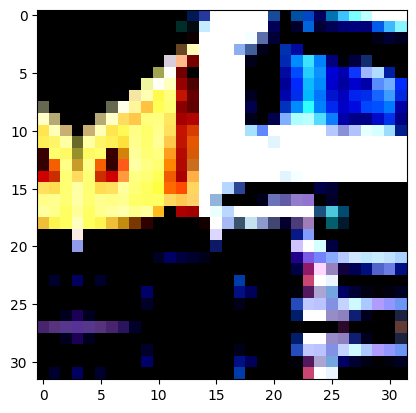

object number:  9
object name:  truck


In [3]:
#3
images, labels = dataset[1]
rgb_images=images.permute(1,2,0).numpy()
objectname=dataset.classes[labels]
plt.imshow(rgb_images)
plt.show()
print("object number: ", labels)
print("object name: ", objectname)

In [4]:
images.shape

torch.Size([3, 32, 32])

In [5]:
#4
batch_size=256

#num_workers are used to leverage multiple cpu cores and loading the images in parallel
#pin_memory avoids repeated allocation and deallocation of memory by using the same portion of memory(RAM) for loading each batch of data
#this is possible only because all of our images are 32x32 pixels
training_loader=DataLoader(dataset, batch_size,shuffle=True, num_workers=8, pin_memory=True)
validation_loader=DataLoader(validation_testset, batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(len(training_loader.dataset))  # For training dataset
print(len(validation_loader.dataset))  # For test dataset


50000
10000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
#5
#defining the model, here we are gonna use a larger model, wideresnet22 having 22 convolutional layers, 1 key changes to our
# model is the addition of residual block in which the inputs get added back to the output feature map obtained by the passing
# of inputs through one or more convolutional layers
# also applying batch normalization after each convolutional layer to reduce loss and increase the accuracy very fast.

#conv2d function
def Conv_2d(in_channels, out_channels, kernel=3, stride=1):
  return nn.Conv2d(in_channels=in_channels,
                   out_channels=out_channels,
                   kernel_size=kernel,
                   stride=stride,
                   padding=kernel//2,
                   bias=False)

# the order we need to follow is apply batchnormalization, relu function, conv2d layer
def batch_relu_conv2d(in_channels, out_channels):
  return nn.Sequential(nn.BatchNorm2d(in_channels),
                       nn.ReLU(inplace=True),
                       Conv_2d(in_channels,out_channels))

#things happening inside a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.batchnorm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = batch_relu_conv2d(out_channels, out_channels)

        # Define shortcut branch
        if in_channels != out_channels or stride != 1:
            # Match both channels and spatial dimensions
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        else:
            self.shortcut = nn.Identity()  # No change if dimensions match exactly

    def forward(self, x):
        x = F.relu(self.batchnorm(x), inplace=True)
        r = self.shortcut(x)  # Ensure `r` matches dimensions of `x`
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x + r


#making groups / blocks
def make_blocks(N,in_channels, out_channels, stride):
  start=ResidualBlock(in_channels, out_channels, stride)
  rest = [ResidualBlock(out_channels, out_channels) for j in range(1,N)]
  return [start]+rest

#flattening class
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x.view(x.size(0),-1)

#wide resnet class
class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
    super().__init__()
    #increase channels to n_start using conv layer
    layers=[Conv_2d(3,n_start)]
    n_channels = [n_start]

    #add groups of basic blocks(increase channels and downsample)
    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*k)
      stride=2 if i>0 else 1
      layers+=make_blocks(N, n_channels[i], n_channels[i+1], stride)

    #pool, flatten and add linear layers for classification
    layers+=[nn.BatchNorm2d(n_channels[3]),
             nn.ReLU(),
             nn.AdaptiveAvgPool2d(1),
             nn.Flatten(),
             nn.Linear(n_channels[3], n_classes)]

    self.features = nn.Sequential(*layers)

  def forward(self, x):
    return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=10,k=6)

model = wrn_22()

In [8]:
for images, labels in training_loader:
  prediction = model(images)

KeyboardInterrupt: 

In [ ]:
print(images.shape)
print(prediction.shape)